# Trying RT with $a,b$ instead of $a,b_b$

## Inspired by Sydor et al. 2002, 2004

In [1]:
# imports

from importlib import reload

import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime, time
import random 

import pandas
import seaborn as sns

from oceancolor.tara import io as tara_io
from oceancolor.ph import pigments
from oceancolor.hydrolight import loisel23
from oceancolor.utils import spectra
from oceancolor.utils import plotting

In [2]:
%matplotlib ipympl

# Load

In [4]:
ds = loisel23.load_ds(4,0)
ds

<xarray.Dataset> Size: 18MB
Dimensions:  (Lambda: 81, IOP_Scenario: 3320)
Coordinates:
  * Lambda   (Lambda) float32 324B 350.0 355.0 360.0 365.0 ... 740.0 745.0 750.0
Dimensions without coordinates: IOP_Scenario
Data variables: (12/17)
    Rrs      (IOP_Scenario, Lambda) float32 1MB 0.01176 0.01201 ... 3.041e-05
    Ed_0+    (IOP_Scenario, Lambda) float32 1MB 0.7753 0.7314 ... 1.237 1.222
    Lw       (IOP_Scenario, Lambda) float32 1MB 0.009118 0.008785 ... 3.716e-05
    Lu_0+    (IOP_Scenario, Lambda) float32 1MB 0.04075 0.03903 ... 0.0624
    a        (IOP_Scenario, Lambda) float32 1MB 0.03096 0.02925 ... 2.83 2.85
    anw      (IOP_Scenario, Lambda) float32 1MB 0.02386 0.02245 ... 0.0004
    ...       ...
    bph      (IOP_Scenario, Lambda) float32 1MB 0.04521 0.04454 ... 0.1008
    bd       (IOP_Scenario, Lambda) float32 1MB 0.03323 0.03239 ... 0.03513
    bb       (IOP_Scenario, Lambda) float32 1MB 0.006968 0.006587 ... 0.001876
    bbnw     (IOP_Scenario, Lambda) float32 1MB 0.00105 0.001028 ... 0.001641
    bbph     (IOP_Scenario, Lambda) float32 1MB 0.0004521 0.0004454 ... 0.001008
    bbd      (IOP_Scenario, Lambda) float32 1MB 0.0005982 0.000583 ... 0.0006324

## Unpack for convenience

In [5]:
wave = ds.Lambda.data
Rrs = ds.Rrs.data
a = ds.a.data
bb = ds.bb.data
b = ds.b.data

# $u'$

In [6]:
up = b / (a+b)
up.shape

(3320, 81)

# $r_{\rm rs}$

In [7]:
A, B = 0.52, 1.17
rrs = Rrs / (A + B*Rrs)

# Wavelengths

In [8]:
i370 = np.argmin(np.abs(wave-370.))
i440 = np.argmin(np.abs(wave-440.))
i500 = np.argmin(np.abs(wave-500.))
i600 = np.argmin(np.abs(wave-600.))

In [9]:
def rrs_func(uval, G1, G2):
    rrs = G1*uval + G2*uval**2
    return rrs

In [10]:
sydor_Rrs = Rrs / (1-2*np.pi*Rrs)

# Fit

In [58]:
save_ans = []
for ii in [i370, i440, i500, i600]:
    ans, cov = curve_fit(rrs_func, u[:,ii], rrs[:,ii], p0=[0.1, 0.1], sigma=np.ones_like(u[:,ii])*0.0003)
    save_ans.append(ans)

In [56]:
save_ans[-1]

array([ 0.1165968 , -1.18249731])

# Plots

----

## Sydor $b/a$

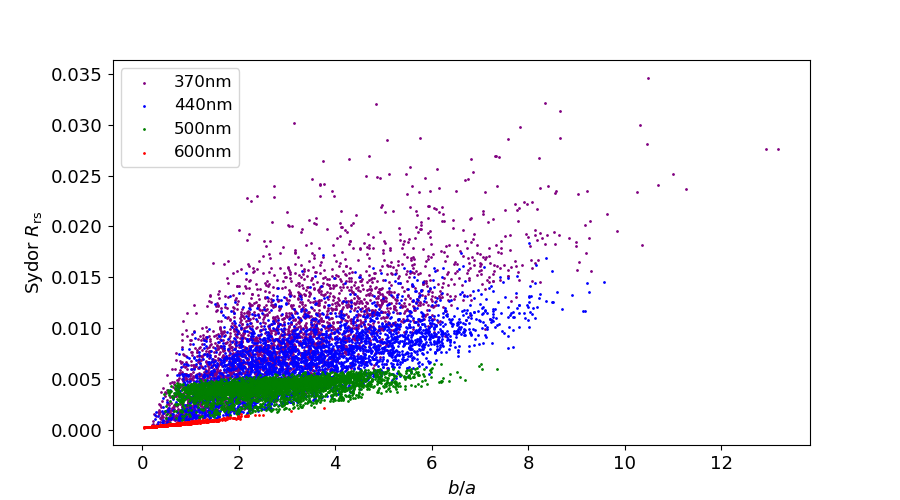

In [12]:
fig = plt.figure(figsize=(9,5))

plt.clf()
ax = plt.gca()
for lbl, clr, idx in zip(['370nm', '440nm', '500nm', '600nm'],
                              ['purple', 'b','g', 'r'],
                              [i370, i440, i500, i600],
                        ):
    ax.scatter(b[:,idx]/a[:,idx], sydor_Rrs[:,idx], color=clr, s=1., label=lbl)
    #irrs = rrs_func(u[:,idx], ans[0], ans[1])
    #usrt = np.argsort(u[:,idx])
    #ax.plot(u[usrt,idx], irrs[usrt], '-', color=clr, label=f'Fit: G0={ans[0]:0.2f}, G1={ans[1]:0.2f}')
#
ax.set_xlabel(r'$b/a$')
ax.set_ylabel(r'Sydor $R_{\rm rs}$')
ax.legend(fontsize=12)
plotting.set_fontsize(ax, 13.)
#
plt.show()

## Replace $b_b$ with $b$

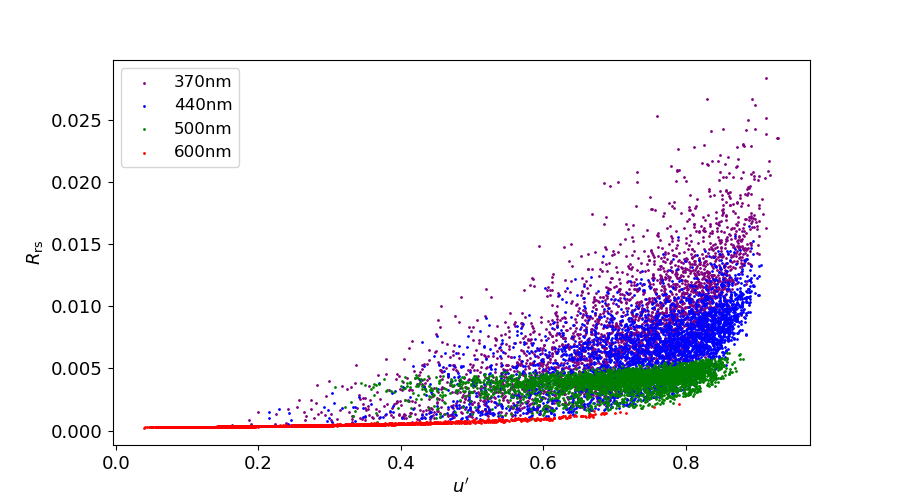

In [18]:
fig = plt.figure(figsize=(9,5))

plt.clf()
ax = plt.gca()
for lbl, clr, idx in zip(['370nm', '440nm', '500nm', '600nm'],
                              ['purple', 'b','g', 'r'],
                              [i370, i440, i500, i600],
                        ):
    ax.scatter(b[:,idx]/(b[:,idx]+a[:,idx]), Rrs[:,idx], color=clr, s=1., label=lbl)
    #irrs = rrs_func(u[:,idx], ans[0], ans[1])
    #usrt = np.argsort(u[:,idx])
    #ax.plot(u[usrt,idx], irrs[usrt], '-', color=clr, label=f'Fit: G0={ans[0]:0.2f}, G1={ans[1]:0.2f}')
#
ax.set_xlabel(r"$u'$")
ax.set_ylabel(r"$R_{\rm rs}$")
ax.legend(fontsize=12)
plotting.set_fontsize(ax, 13.)
#
plt.show()

# Exploring $b$

In [19]:
def pow_func(wave, B, beta):
    return B*(440./wave)**beta

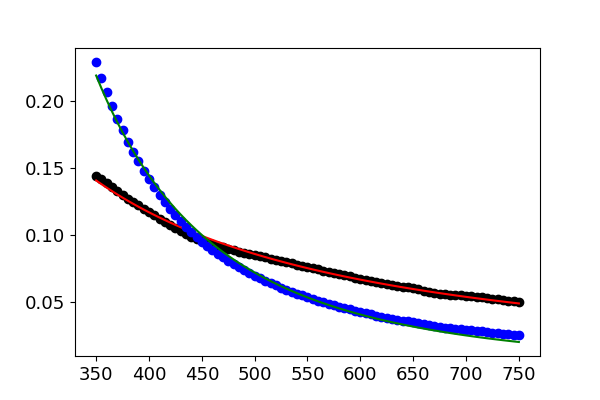

In [26]:
idx = 2000
i440 = np.argmin(np.abs(wave-440.))

# Fit
ans, cov = curve_fit(pow_func, wave, b[idx], p0=[b[idx][i440], 1.])
ans2, cov2 = curve_fit(pow_func, wave, bb[idx], p0=[bb[idx][i440], 0.1])

fig = plt.figure(figsize=(6,4))

plt.clf()
ax = plt.gca()

ax.plot(wave, b[idx], 'ko', label=r'$b$')
ax.plot(wave, pow_func(wave, ans[0], ans[1]), 'r-', label=r'$b$ Fit')

# bb
ax.plot(wave, 30*bb[idx], 'bo', label=r'$b_b$')
ax.plot(wave, 30*pow_func(wave, ans2[0], ans2[1]), 'g-', label=r'$b_b$ Fit')

plotting.set_fontsize(ax, 13.)
#
plt.show()